In [1]:
import sys
sys.path.append('../inxai')

In [2]:
from inxai import *
from sklearn.datasets import make_classification, make_moons, make_circles, make_blobs
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
#import eli5
#from eli5.sklearn import PermutationImportance
from sklearn.compose import ColumnTransformer
from anchor import utils
from anchor import anchor_tabular

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize, MinMaxScaler
import shap
import lime
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb 
from sklearn.neighbors import NearestNeighbors

In [3]:
def minmaxdf(df, scale=[-1,1]):
    # Using MinMaxScaler
    min_max_scaler = MinMaxScaler(feature_range=scale)    
    # Stack everything into a single column to scale by the global min / max
    tmp = df.to_numpy().reshape(-1,1)
    scaled = min_max_scaler.fit_transform(tmp).reshape(len(df), df.shape[1])
    return scaled
    

In [4]:
dataset_size = 1000
neighborhood_size=100

# Create synthetic classification dataset

# Execution times

In [5]:
def prepare(dataset_size=1000, noise=0.25):
    X,y = sklearn.datasets.make_moons(n_samples=dataset_size,  noise=0.25, random_state=0)#factor=0.5
    Xdf = pd.DataFrame(X, columns=['x1','x2'])
    X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X), y, test_size=0.33, random_state=42)
    X_train.columns = ['x1','x2']
    X_test.columns = ['x1','x2']
    svc = SVC(kernel='rbf',probability=True)
    svc.fit(X_train, y_train)
    svc_preds = svc.predict(X_test)
    xclf = xgb.XGBClassifier()
    xclf.fit(X_train.values, y_train)
    return svc, xclf, X_train, X_test, y_train, y_test

In [6]:
def execution_times_lime(model, X_test):
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=list(X_train.columns), class_names=['0','1'], discretize_continuous=True)
    idx = len(X_test)-1
    exp = explainer.explain_instance(X_test.iloc[idx], model.predict_proba, num_features=2, top_labels=1)
    
    
def execution_times_anchor(model, X_test):
    explainer = anchor_tabular.AnchorTabularExplainer(
    ['0','1'],
    feature_names = X_train.columns,
    train_data = X_train.values,
    categorical_names={})
    np.random.seed(1)
    for idx in range(0,len(X_test)):
        exp = explainer.explain_instance(X_test.iloc[idx].values, model.predict, threshold=0.95)
                           
                        
    
def execution_times_shap(model, X_test):
    warnings.filterwarnings('ignore')
    # use Kernel SHAP to explain test set predictions
    explainer = shap.KernelExplainer(model.predict_proba, X_train, link="logit")
    shap_values = explainer.shap_values(X_test, nsamples=100)
    
    
def execution_times_lux(model, X_test, y_test):
    for idx in range(0,len(X_test)):
        nn = NearestNeighbors(neighborhood_size)
        X_pos_only = X_test[y_test==1]
        nn.fit(X_pos_only)
        _,ids_1 = nn.kneighbors(np.array(X_test.iloc[idx]).reshape(1,-1))
        X_neg_only = X_test[y_test==0]
        nn.fit(X_neg_only)
        _,ids_0 = nn.kneighbors(np.array(X_test.iloc[idx]).reshape(1,-1))
        X_train_sample = pd.concat((X_pos_only.iloc[ids_1.ravel()], X_neg_only.iloc[ids_0.ravel()]))
        y_train_sample = model.predict_proba(X_train_sample.values)[:,1]

        with open('lux.numeric_tmp.arff', 'w') as file:
            file.write('@relation lux\n\n')
            file.write('@attribute x1 @REAL\n')
            file.write('@attribute x2 @REAL\n')
            file.write('@attribute class {1,0}\n\n')

            file.write('@data\n')
            for i in range(0, len(X_train_sample)):
                file.write('{:.2f}'.format(X_train_sample.iloc[i,0])+','+'{:.2f}'.format(X_train_sample.iloc[i,1])+',1['+'{:.2f}'.format(y_train_sample[i])+']\n')


        !java -jar udt.jar lux.numeric_tmp.arff dot > explanation.dot

# Comaprison times

In [7]:
import time

In [9]:
import warnings
results = []
for dataset_size in range(1000,int(2000),1000):
    model1, model2, X_train, X_test, y_train, y_test =  prepare(dataset_size=dataset_size, noise=0.25)
    
    start_time = time.time()
    execution_times_lime(model1, X_test)
    #execution_times_lime(model2, X_test)
    exec_lime = (time.time() - start_time)
    
    start_time = time.time()
    execution_times_shap(model1, X_test)
    #execution_times_shap(model2, X_test)
    exec_shap = (time.time() - start_time)
        
    start_time = time.time()
    execution_times_anchor(model1, X_test)
    #execution_times_anchor(model2, X_test)
    exec_anchor = (time.time() - start_time)
        
    start_time = time.time()
    execution_times_lux(model1, X_test, y_test)
    #execution_times_lux(model2, X_test, y_test)
    exec_lux = (time.time() - start_time)
    
    results.append([dataset_size, exec_lime, exec_shap, exec_anchor, exec_lux])

Using 670 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [10]:
class LuxModel():
    def get_importances(self,model, X, y):
        !echo "" > importances.csv
        for i,r in X.iterrows():
            self.execution_lux(model, X, y,i)
            !java -jar udt.jar lux.numeric_tmp.arff infogain >> importances.csv
        imps = pd.read_csv('importances.csv', names=['x1','x2'], header=None)
        return imps
    
    def execution_lux(self, model, X_test, y_test, idx):
        nn = NearestNeighbors(neighborhood_size)
        X_pos_only = X_test[y_test==1]
        nn.fit(X_pos_only)
        _,ids_1 = nn.kneighbors(np.array(X_test.loc[idx]).reshape(1,-1))
        X_neg_only = X_test[y_test==0]
        nn.fit(X_neg_only)
        _,ids_0 = nn.kneighbors(np.array(X_test.loc[idx]).reshape(1,-1))
        X_train_sample = pd.concat((X_pos_only.iloc[ids_1.ravel()], X_neg_only.iloc[ids_0.ravel()]))
        y_train_sample = model.predict_proba(X_train_sample.values)[:,1]

        with open('lux.numeric_tmp.arff', 'w') as file:
            file.write('@relation lux\n\n')
            file.write('@attribute x1 @REAL\n')
            file.write('@attribute x2 @REAL\n')
            file.write('@attribute class {1,0}\n\n')

            file.write('@data\n')
            for i in range(0, len(X_train_sample)):
                file.write('{:.2f}'.format(X_train_sample.iloc[i,0])+','+'{:.2f}'.format(X_train_sample.iloc[i,1])+',1['+'{:.2f}'.format(y_train_sample[i])+']\n')

        

# Stability

In [11]:
model1, model2, X_train, X_test, y_train, y_test =  prepare(dataset_size=dataset_size, noise=0.25)

In [12]:
import warnings
warnings.filterwarnings('ignore')
gm = GlobalFeatureMetric()
lux = LuxModel()
shap_res=generate_per_instance_importances(models=model1, X=X_test, y=y_test, framework='kernel_shap')
lime_res = generate_per_instance_importances(models=model1, X=X_test, y=y_test, framework='lime')
lux_res = lux.get_importances(model1,X_test, y_test)
shap_res = minmaxdf(pd.DataFrame(shap_res), scale=[-1,1])
lime_res = minmaxdf(pd.DataFrame(lime_res), scale=[-1,1])
lux_res = minmaxdf(pd.DataFrame(lux_res), scale=[-1,1])

Using 330 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


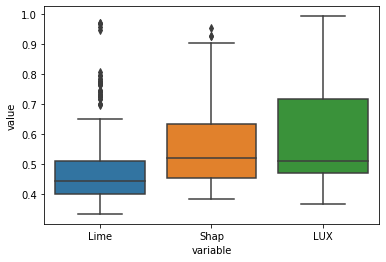

In [13]:
shape_lips = gm.stability(X_test,shap_res ,epsilon=0.5)
lime_lips = gm.stability(X_test,lime_res,epsilon=0.5 )
lux_lips = gm.stability(X_test,lux_res,epsilon=0.5 )

lip_df = pd.DataFrame({'Lime':lime_lips, 'Shap':shape_lips, 'LUX':lux_lips})
sns.boxplot(x="variable", y="value", data=pd.melt(lip_df))

# Consistency

In [14]:
res_lux_con = [lux.get_importances(model1,X_test, y_test),lux.get_importances(model2,X_test, y_test)]

In [15]:
lux = LuxModel()
res_lime_con = generate_per_instance_importances(models=[model1, model2], X=X_test, y=y_test, framework='lime') 
res_shap_con = generate_per_instance_importances(models=[model1, model2], X=X_test, y=y_test, framework='kernel_shap') 
res_lux_con = [lux.get_importances(model1,X_test, y_test),lux.get_importances(model2,X_test, y_test)]

Using 330 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Using 330 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [16]:
res_lime_con = [minmaxdf(pd.DataFrame(rlc), scale=[-1,1]) for rlc in res_lime_con]
res_shap_con = [minmaxdf(pd.DataFrame(rsc), scale=[-1,1]) for rsc in res_shap_con]
res_lux_con = [minmaxdf(pd.DataFrame(rlc), scale=[-1,1]) for rlc in res_lux_con]

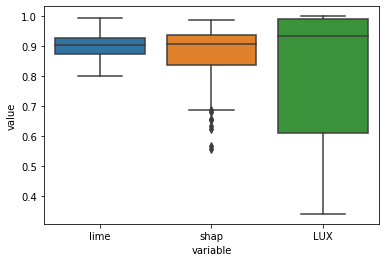

In [17]:
lime_cons = gm.consistency(res_lime_con)
shap_cons = gm.consistency(res_shap_con)
lux_cons = gm.consistency(res_lux_con)
cons_df = pd.DataFrame({'lime':lime_cons, 'shap':shap_cons,'LUX':lux_cons})
sns.boxplot(x="variable", y="value", data=pd.melt(cons_df))

[Text(0, 0.5, 'Stability'), Text(0.5, 0, 'Explanation framework')]

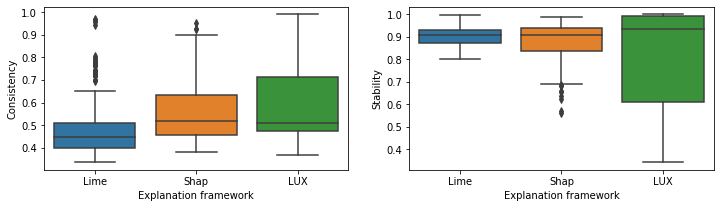

In [25]:
fig, axs = plt.subplots(1,2, figsize=(12,3))
lip_df = pd.DataFrame({'Lime':lime_lips, 'Shap':shape_lips, 'LUX':lux_lips})
sns.boxplot(x="variable", y="value", data=pd.melt(lip_df), ax=axs[0], notch=False)
axs[0].set(xlabel='Explanation framework', ylabel='Consistency')

cons_df = pd.DataFrame({'Lime':lime_cons, 'Shap':shap_cons,'LUX':lux_cons})
sns.boxplot(x="variable", y="value", data=pd.melt(cons_df),ax=axs[1], notch=False)
axs[1].set(xlabel='Explanation framework', ylabel='Stability')


In [26]:
fig.savefig('stabcons.png', bbox_inches='tight')

## LUX ocnsistency issues

[Text(0.5, 1.0, 'XGB uncertainty in predictions')]

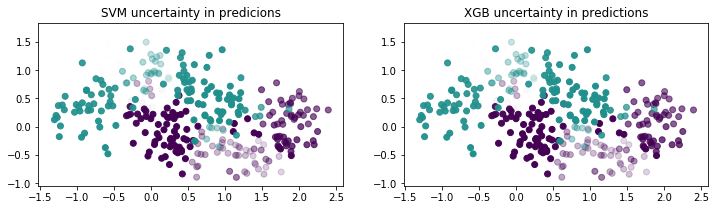

In [20]:
import matplotlib.pylab as plt
from matplotlib import colors,cm

fig, ax = plt.subplots(1, 2, figsize=(12,3))

y_test_proba = model1.predict_proba(X_test)
confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'SVC_0':y_test_proba[:,0], 'SVC_1':y_test_proba[:,1]})))

y_test_proba_xg = model2.predict_proba(X_test.values)
confidence_xgb =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'XGB_0':y_test_proba_xg[:,0],'XGB_1':y_test_proba_xg[:,1]})))

X_test_1 = X_test.iloc[y_test==1]
X_test_2 = X_test.iloc[y_test==0]
X_test_1.columns=['x1','x2']

cmapp = cm.viridis


c=0
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_1['x1'], X_test_1['x2'], c=cons_df.iloc[y_test==1,2].values, cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_2['x1'], X_test_2['x2'], c=cons_df.iloc[y_test==0,2].values, cmap=cmap)#, ec=None, s=10**2)
ax[0].set(title='SVM uncertainty in predicions')


c=0

cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_1['x1'], X_test_1['x2'], c=cons_df.iloc[y_test==1,2].values, cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_2['x1'], X_test_2['x2'], c=cons_df.iloc[y_test==0,2].values, cmap=cmap)#, ec=None, s=10**2)
ax[1].set(title='XGB uncertainty in predictions')


## Lux stability issues

[Text(0.5, 1.0, 'XGB uncertainty in predictions')]

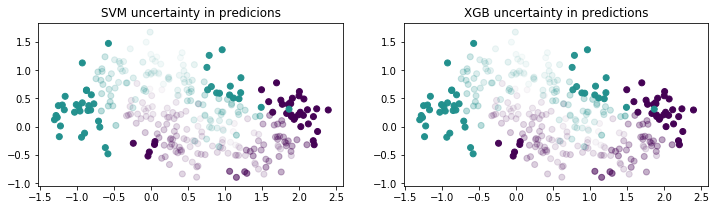

In [21]:
import matplotlib.pylab as plt
from matplotlib import colors,cm

fig, ax = plt.subplots(1, 2, figsize=(12,3))

y_test_proba = model1.predict_proba(X_test)
confidence_svc =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'SVC_0':y_test_proba[:,0], 'SVC_1':y_test_proba[:,1]})))

y_test_proba_xg = model2.predict_proba(X_test.values)
confidence_xgb =   pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame({'XGB_0':y_test_proba_xg[:,0],'XGB_1':y_test_proba_xg[:,1]})))

X_test_1 = X_test.iloc[y_test==1]
X_test_2 = X_test.iloc[y_test==0]
X_test_1.columns=['x1','x2']

cmapp = cm.viridis


c=0
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_1['x1'], X_test_1['x2'], c=lip_df.iloc[y_test==1,2].values, cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[0].scatter(X_test_2['x1'], X_test_2['x2'], c=lip_df.iloc[y_test==0,2].values, cmap=cmap)#, ec=None, s=10**2)
ax[0].set(title='SVM uncertainty in predicions')


c=0

cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_1['x1'], X_test_1['x2'], c=lip_df.iloc[y_test==1,2].values, cmap=cmap)#, ec=None, s=10**2)


c=int(255*.5)
cmap = colors.LinearSegmentedColormap.from_list(
        'incr_alpha', [(0, (*tuple(cmapp.colors[c]),0)), (1, cmapp.colors[c])])
ax[1].scatter(X_test_2['x1'], X_test_2['x2'], c=lip_df.iloc[y_test==0,2].values, cmap=cmap)#, ec=None, s=10**2)
ax[1].set(title='XGB uncertainty in predictions')
